In [1]:
import sys
import codecs
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import mpld3
import pandas as pd

%matplotlib inline


In [2]:
def load_embeddings(file_name):
    with codecs.open(file_name, 'r', 'utf-8') as f_in:
        vocabulary, wv = zip(*[line.strip().split(' ', 1) for line in f_in])
    wv = np.loadtxt(wv)
    return wv, vocabulary


In [3]:
colors = {
    'Da Vinci Code -': 'b', 
    'Da Vinci Code +': 'c',
    'Harry Potter -' : 'r',
    'Harry Potter +' : 'lightsalmon',
    'Brokeback Mountain -': 'y',
    'Brokeback Mountain +': 'yellow',
    'Mission Impossible -': 'g',
    'Mission Impossible +': 'lime',    
}


film_label = {
    'vinci': ('Da Vinci Code -', 'Da Vinci Code +'),
    'potter': ('Harry Potter -', 'Harry Potter +'),
    'brokeback': ('Brokeback Mountain -', 'Brokeback Mountain +'),
    'impossible': ('Mission Impossible -', 'Mission Impossible +')
}

filmwords = {'mission', 'impossible', 'harry', 'potter', 'code', 'da', 'vinci', 'mountain', 'brokeback'}

In [4]:
embeddings_file = '../output/kaggle_w2v_word_vectors.txt'
wv, vocabulary = load_embeddings(embeddings_file)
vocabulary = np.array(vocabulary)
vocabulary_dict = {i: idx for idx, i in enumerate(vocabulary)}
print("Loaded {} words".format(len(vocabulary)))

Loaded 1529 words


In [5]:
tweets_w2v_file = '../output/kaggle_w2v_tweets.txt'
with open(tweets_w2v_file) as f:
    lines_w2v = [i.split(',') for i in f.readlines()]
    labels_w2v = [int(i[0].strip().split('_')[-1]) for i in lines_w2v]
    tweets_w2v = [i[1].strip() for i in lines_w2v]
    
tweets_w2v = np.array(tweets_w2v)

print("Loaded {} tweets".format(len(tweets_w2v)))

Loaded 1411 tweets


In [14]:
m, tweets_w2v_avg, point_labels = [], [], []
for idx, i in enumerate(tweets_w2v):
    w = set(i.split())
    for k in film_label:
        if k in w:
            # vecs = [wv[vocabulary_dict[word]] for word in w if word in vocabulary_dict]
            vecs = [wv[vocabulary_dict[word]] for word in w if word in vocabulary_dict and word not in filmwords]
            if not len(vecs):
                break
            
            m.append(idx)
            vecs = np.array(vecs)
            tweets_w2v_avg.append(np.mean(vecs, axis=0))
            point_labels.append(film_label[k][labels_w2v[idx]])
            break
            
tweets_w2v = tweets_w2v[m]
tweets_w2v_avg = np.array(tweets_w2v_avg)
print("Selected {} tweets".format(len(tweets_w2v_avg)))

Selected 1394 tweets


In [15]:
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(tweets_w2v_avg)

/Library/Python/2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


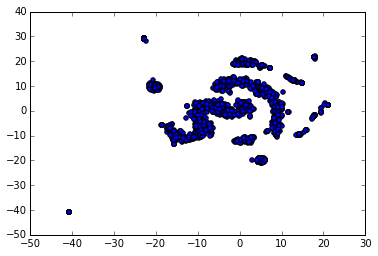

In [16]:
plt.scatter(Y[:, 0], Y[:, 1])

In [20]:
# plt.scatter(Y[:, 0], Y[:, 1], c=c)
# for label, x, y in zip(tweets_w2v, Y[:, 0], Y[:, 1]):
#     plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')

In [21]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}


In [19]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=Y[:, 0], y=Y[:, 1], label=point_labels, title=tweets_w2v)) 
df[df.label == 'Harry Potter -']['title'].head().tolist()

['problem this course harry potter sucks ass indicative overall decline englishspeaking culture hands predictability prettypackaging',
 'fade creature death like demeantor harry potter suck soul mouth',
 'hate harry potter jelly beans',
 'favourite harry potter film stonechamber secretsprisoner azkabangoblet firei like equally hate harry potter think stupid question',
 'ill probably get murdered thousand times everyone saying it hate harry potter']

In [24]:
#group by cluster
groups = df.groupby('label')

# plt.scatter(Y[:, 0], Y[:, 1], c=c)
# for label, x, y in zip(vocabulary, Y[:, 0], Y[:, 1]):
#     plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none;
}

svg.mpld3-figure {
/* margin-left: -200px;  */
}
"""

# Plot 
fig, ax = plt.subplots(figsize=(15, 15)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=10, 
                    mec='none', alpha=1, color=colors[name], label=name)
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(loc='upper left', numpoints=1)

# uncomment the below to export to html
with open('./films_without_names.html', 'w') as f:
    html = mpld3.fig_to_html(fig)
    f.write("""
        <style>
            body {padding:100px;}
        </style>
    """)
    f.write(html)
    
mpld3.display() #show the plot